# **Introduction:**

This notebook is created based on prior work built by Cameron Cruz: https://towardsdatascience.com/easy-image-classification-with-tensorflow-2-0-f734fee52d13
with a few personal tweaks and tinkering. The purpose of this notebook is to implement CNN to identify cactus from aerial images, the original data can be found from Kaggle: https://www.kaggle.com/c/aerial-cactus-identification



# 0. Set-up work directory and import data

In [1]:
# Setup Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"eddie2020","key":"5f0699e976b55081027c5e3bd4b06619"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json


total 4
-rw------- 1 root root 65 Jun  3 02:54 kaggle.json
{"username":"eddie2020","key":"5f0699e976b55081027c5e3bd4b06619"}

In [4]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 5.3MB 9.6MB/s 
     |████████████████████████████████| 102kB 33.4MB/s 
     |████████████████████████████████| 51kB 26.5MB/s 
     |████████████████████████████████| 112kB 57.9MB/s 


In [5]:
!kaggle competitions download -c aerial-cactus-identification -p data

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 44.8MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 52.9MB/s]
100% 4.20M/4.20M [00:00<00:00, 38.0MB/s]

 26% 5.00M/19.2M [00:00<00:00, 22.7MB/s]
100% 19.2M/19.2M [00:00<00:00, 64.1MB/s]


In [0]:
# Unzip dataset
!unzip data/train.zip -d data
!unzip data/test.zip -d data

#1.  Install TF 2.0 and other packages

In [7]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 51kB/s 
     |████████████████████████████████| 61kB 27.5MB/s 
     |████████████████████████████████| 3.0MB 33.7MB/s 
     |████████████████████████████████| 419kB 51.9MB/s 


In [28]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

print(tf.__version__)

2.0.0-alpha0


# 2. Inspect Data

In [15]:
train_csv = pd.read_csv('data/train.csv')
print(train_csv.head(50))

                                      id  has_cactus
0   0004be2cfeaba1c0361d39e2b000257b.jpg           1
1   000c8a36845c0208e833c79c1bffedd1.jpg           1
2   000d1e9a533f62e55c289303b072733d.jpg           1
3   0011485b40695e9138e92d0b3fb55128.jpg           1
4   0014d7a11e90b62848904c1418fc8cf2.jpg           1
5   0017c3c18ddd57a2ea6f9848c79d83d2.jpg           1
6   002134abf28af54575c18741b89dd2a4.jpg           0
7   0024320f43bdd490562246435af4f90b.jpg           0
8   002930423b9840e67e5a54afd4768a1e.jpg           1
9   00351838ebf6dff6e53056e00a1e307c.jpg           1
10  003519dd841a97ed16481fa0657df04d.jpg           1
11  003bb64852016d9c87871ddd8e25ab03.jpg           0
12  003ec9bcef67171ba49fe4c3b7c80aec.jpg           1
13  003eeb9a86e36cd6328c778c15df890d.jpg           1
14  0045d0f2aec739370eaefac79ee5b96c.jpg           0
15  004fceec9b9b6a31dc9b0540fd69c692.jpg           1
16  0051207eb794887c619341090de84b50.jpg           0
17  0052d90950c3f08ed778d638a956fd43.jpg      

# 3. Sanity check for images (w/ and without cactus)

In [0]:
# filter photos 
no_cactus = train_csv.loc[train_csv['has_cactus'] == 0]
cactus = train_csv.loc[train_csv['has_cactus'] == 1]

In [0]:
no_cactus_list = ['data/train/' + id for id in no_cactus['id'].tolist()]
cactus_list = ['data/train/' + id for id in cactus['id'].tolist()]


In [0]:
from IPython.display import display, Image
import PIL.Image
from io import BytesIO
import cv2
from glob import glob

def show_image(img, fmt='png'):
    a = np.uint8(img)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))



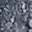

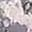

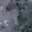

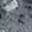

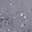

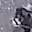

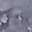

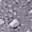

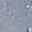

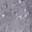

In [60]:
# print out the first 10 no-catcus images 

for image in no_cactus_list[:10]:
    img = cv2.imread(image)
    show_image(img)

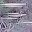

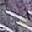

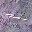

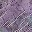

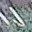

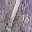

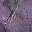

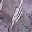

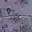

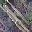

In [61]:
# print out the first 10 images with catcus

for image in cactus_list[:10]:
    img = cv2.imread(image)
    show_image(img)

#4.  Preprocess Data

In [0]:
filenames = ['data/train/' + fname for fname in train_csv['id'].tolist()]
labels = train_csv['has_cactus'].tolist()

train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.8,
                                                                            random_state=1357)
# num_train = len(train_filenames)
# num_test = len(val_filenames)
print(num_train)
print(num_test)

In [0]:
def image_process(filename, label):
  pic_filename = tf.io.read_file(filename)
  pic_decode = tf.image.decode_jpeg(pic_filename)
  pic_normalize = (tf.cast(pic_decode, tf.float32)/127.5) - 1
  pic_resize = tf.image.resize(pic_normalize, (128, 128))
  return pic_resize, label

#5.  Set up batch size, train, test data

In [0]:
batch = 25

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels))).map(image_process).shuffle(buffer_size=500).batch(batch)

test_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels))).map(image_process).batch(batch)

# 6. Define model

In [0]:
# Base model with MobileNetV2
pic_size = (128, 128, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=pic_size,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [0]:
learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# 7. Train CNN model

In [0]:
epoch = 50
steps_per_epoch = round(num_train)/epoch
test_steps = 20

In [0]:
history = model.fit(train_data.repeat(),
                    epochs=epoch,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=test_data.repeat(), 
                    validation_steps=test_steps)

Epoch 1/50
280/280 [==============================] - 18s 64ms/step - loss: 0.6464 - accuracy: 0.7599 - val_loss: 0.7767 - val_accuracy: 0.6160
Epoch 2/50
280/280 [==============================] - 10s 36ms/step - loss: 0.3276 - accuracy: 0.8746 - val_loss: 1.0717 - val_accuracy: 0.5480
Epoch 3/50
280/280 [==============================] - 10s 36ms/step - loss: 0.2477 - accuracy: 0.9054 - val_loss: 1.1164 - val_accuracy: 0.5600
Epoch 4/50
280/280 [==============================] - 10s 35ms/step - loss: 0.2115 - accuracy: 0.9176 - val_loss: 1.1496 - val_accuracy: 0.5820
Epoch 5/50
280/280 [==============================] - 10s 36ms/step - loss: 0.1913 - accuracy: 0.9253 - val_loss: 0.9235 - val_accuracy: 0.6520
Epoch 6/50
280/280 [==============================] - 10s 35ms/step - loss: 0.1743 - accuracy: 0.9351 - val_loss: 0.7568 - val_accuracy: 0.7060
Epoch 7/50
280/280 [==============================] - 10s 35ms/step - loss: 0.1796 - accuracy: 0.9331 - val_loss: 0.6629 - val_accuracy:

In [0]:
# Save model weights
model.save_weights('weights_MobileNet')

# 8. Check model performance after training

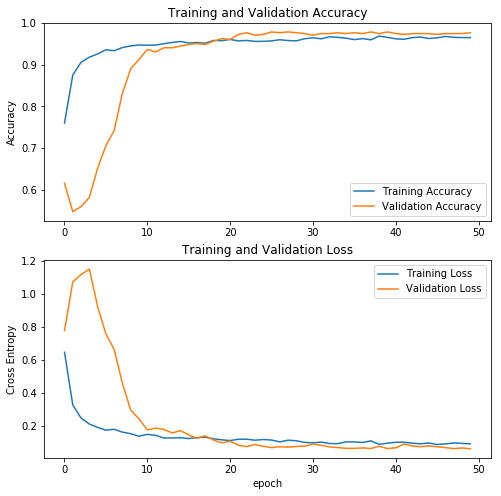

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 9. Fine Tune the model to increase its performance (more epochs)

In [0]:
# Unfreeze all layers of MobileNetV2
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data.repeat(), 
                         steps_per_epoch = steps_per_epoch,
                         epochs=total_epochs, 
                         initial_epoch = num_epochs,
                         validation_data=val_data.repeat(), 
                         validation_steps=val_steps)

In [0]:
# Save fine-tuned model weights
model.save_weights('weights_epoch_50_finetuned.h5')

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

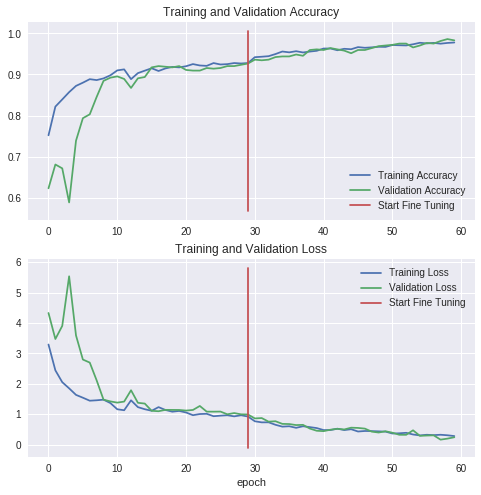

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()